## Downloading Modular PyTorch Scripts

In [27]:
import os
from pathlib import Path
import requests

base_url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular"


files = [
    "data_setup.py",
    "engine.py",
    "model_builder.py",
    "predictions.py",
    "train.py",
    "utils.py"]

target_dir = Path("going_modular")

if target_dir.exists():
    print("Already exists")
else:
    print("Couldn't find, downloading......")
    target_dir.mkdir(parents=True, exist_ok=True)

    for file_name in files:
        file_url = f"{base_url}/{file_name}"
        response = requests.get(file_url)
        response.raise_for_status()

        file_path = target_dir / file_name
        file_path.write_text(response.text)

    print("Downloaded!")

Couldn't find, downloading......
Downloaded!


## Downloading `helper_functions.py` from GitHub

In [4]:
import os
import requests

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"

response = requests.get(url)
response.raise_for_status()

with open("helper_functions.py", 'wb') as f:
    f.write(response.content)

## `download_data` Function

In [7]:
import requests
import zipfile
import os
from pathlib import Path

def download_data(source: str,
                  destination: str,
                  remove_file: bool=True):

    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"{image_path} already exists!")
    else:
        print(f"Couldn't find {image_path}, downloading......")
        image_path.mkdir(exist_ok=True, parents=True)

        target_file_name = Path(source).name

        with open(data_path / target_file_name, 'wb') as f:
            print("downloading.....")
            response = requests.get(source)
            response.raise_for_status()
            f.write(response.content)

        with zipfile.ZipFile(data_path / target_file_name, 'r') as zip_ref:
            print('Unzipping........')
            zip_ref.extractall(image_path)

        if remove_file():
            print("Removing........")
            os.remove(data_path / target_file_name)

    return image_path


In [8]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data/pizza_steak_sushi_20_percent already exists!


## `create_effnetb2_model` Function

In [9]:
from torch import nn
import torch
import torchvision

def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transformer = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed=seed)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transformer

In [10]:
effnetb2, effnetb2_transformer = create_effnetb2_model(num_classes=3,
                                                       seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 125MB/s] 


## Effnetb2 Summary With `Torchinfo`

In [11]:
try:
    from torchinfo import summary

except:
    !pip install torchinfo
    from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", 'output_size', "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

## Dataset Directory Setup

In [12]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Creating DataLoaders with `going_modular`

In [13]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transformer,
                                                                                                 batch_size=32,
                                                                                                 num_workers=0)

In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## Training EfficientNetB2 with `going_modular`

In [15]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

effnetb2_results = engine.train(model=effnetb2,
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader=test_dataloader_effnetb2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


## Plotting Training and Testing Loss Curves

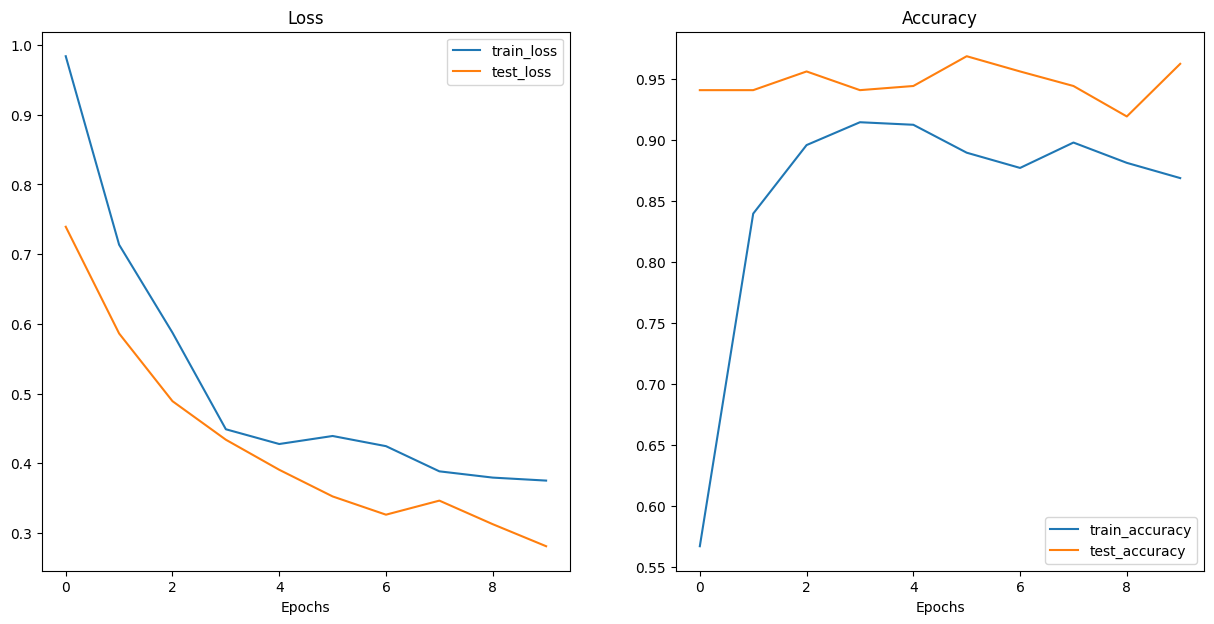

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving Model Weights

In [32]:
model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

save_path = model_dir / "effnetb2.pth"
torch.save(effnetb2.state_dict(), save_path)

## Checking Model File Size in MB

In [34]:
effnetb2_size = save_path.stat().st_size / (1024*1024)
round(effnetb2_size, 2)

29.83

## Counting Total Model Parameters

In [37]:
effnetb2_total_params = 0

for param in effnetb2.parameters():
    effnetb2_total_params += param.numel()

print(f"{effnetb2_total_params:,}")

7,705,221


## Collecting Effnetb2 Statistics

In [38]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size": effnetb2_size}

In [39]:
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size': 29.825875282287598}

## `create_vit` Function

In [40]:
def create_vit(num_classes: int=3,
               seed: int=42):

    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transformer = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)


    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes)
    )

    return model, transformer

In [41]:
vit, vit_transformer = create_vit(num_classes=3,
                                  seed=42)

vit, vit_transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 198MB/s]


(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

## ViT-B/16 Summary with `torchinfo`

In [42]:
from torchinfo import summary

summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Creating DataLoaders for ViT-B/16

In [43]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, num_classes = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transformer,
                                                                                       batch_size=32,
                                                                                       num_workers=0)



## Training ViT-B/16 with `going_modular`

In [44]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

torch.manual_seed(42)

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## Plotting Training and Testing Loss Curves (ViT-B/16)

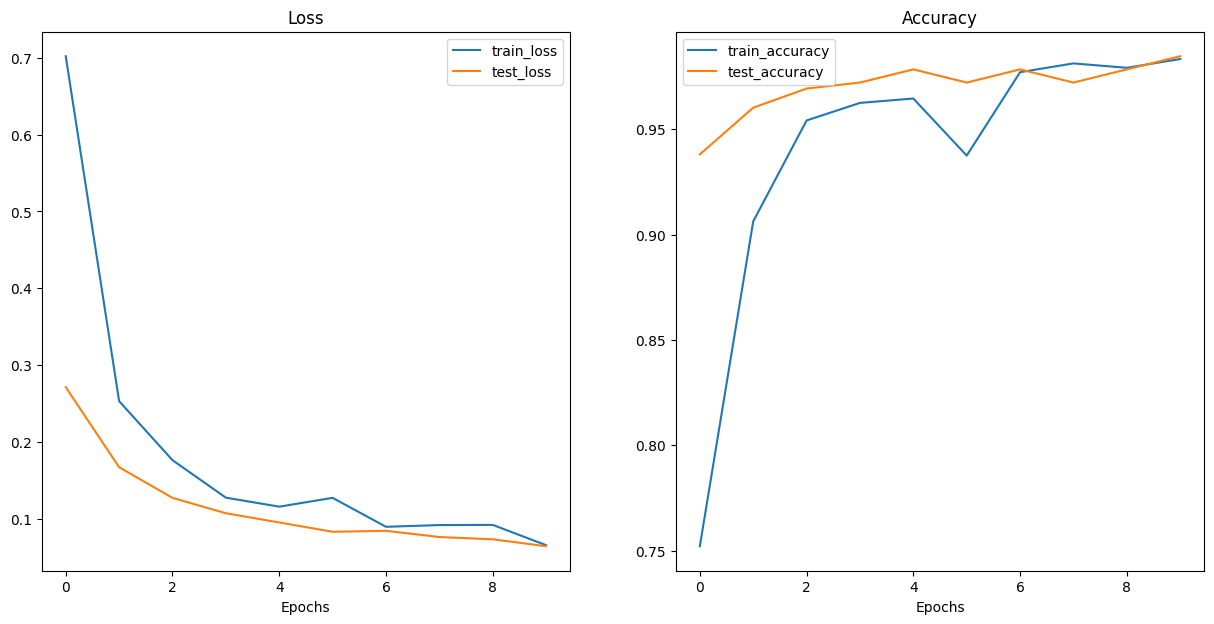

In [46]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving ViT-B/16 Model Weights

In [47]:
save_path = Path("models") / "vit.pth"
torch.save(vit.state_dict(), save_path)

## Checking ViT-B/16 Model File Size in MB

In [51]:
vit_size = Path(r"models/vit.pth").stat().st_size / (1024*1024)
round(vit_size, 2)

327.35

## Counting ViT-B/16 Total Parameters

In [54]:
vit_total_params = 0

for param in vit.parameters():
    vit_total_params += param.numel()

print(f"{vit_total_params:,}")

85,800,963


## Collecting ViT-B/16 Model Statistics

In [55]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size": vit_size}

vit_stats

{'test_loss': 0.06443452327512204,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size': 327.3528051376343}

## Listing Test Data Image Paths

In [56]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:3]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg')]

## `pred_and_store` Function

In [57]:
import pathlib
from typing import List
from tqdm.auto import tqdm
from PIL import Image
from timeit import default_timer as timer

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transformer: torchvision.transforms.Compose,
                   class_names: List[str],
                   device: torch.device='cpu'):

    pred_list = []
    model.to(device)
    model.eval()

    for path in tqdm(paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.name
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)
        transformed_img = transformer(img).unsqueeze(0).to(device)

        with torch.inference_mode():
            pred_logits = model(transformed_img)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label]


            pred_dict["pred_prob"] = round(pred_prob.max().item(), 4)
            pred_dict["pred_class"] = pred_class

        end_time = timer()

        pred_dict["timer_for_pred"] = round(end_time - start_time, 4)
        pred_dict["correct"] = pred_class == class_name

        pred_list.append(pred_dict)


    return pred_list



## Running Predictions with EfficientNetB2

In [58]:
effnet_b2_pred_dicts = pred_and_store(paths=test_data_paths,
                                      model=effnetb2,
                                      transformer=effnetb2_transformer,
                                      class_names=class_names,
                                      device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

## Creating a DataFrame of EfficientNetB2 Predictions

In [59]:
import pandas as pd

effnetb2_dataframe = pd.DataFrame(effnet_b2_pred_dicts)
effnetb2_dataframe.head()

,image_path,class_name,pred_prob,pred_class,timer_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9469,steak,0.2518,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9426,steak,0.0906,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4610,steak,0.0846,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7813,steak,0.0905,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7330,steak,0.0870,True


## Counting Correct Predictions in EfficientNetB2 Results

In [60]:
effnetb2_dataframe["correct"].value_counts()

,count
correct,
True,144
False,6


## Average Inference Time (EfficientNetB2)

In [61]:
effnetb2_average_time_per_second = round(effnetb2_dataframe['timer_for_pred'].mean(), 4)
effnetb2_average_time_per_second

np.float64(0.0963)

## Adding Average Inference Time to EfficientNetB2 Stats

In [62]:
effnetb2_stats["time_per_pred_cpu"] =  effnetb2_average_time_per_second
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size': 29.825875282287598,
 'time_per_pred_cpu': np.float64(0.0963)}

## Running Predictions with ViT-B/16

In [63]:
vit_pred_dicts = pred_and_store(paths=test_data_paths,
                                model=vit,
                                transformer=vit_transformer,
                                class_names=class_names,
                                device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [64]:
vit_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9916,
  'pred_class': 'steak',
  'timer_for_pred': 0.5466,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9958,
  'pred_class': 'steak',
  'timer_for_pred': 0.4915,
  'correct': True}]

## Creating a DataFrame of ViT-B/16 Predictions

In [65]:
import pandas as pd

vit_dataframe = pd.DataFrame(vit_pred_dicts)
vit_dataframe.head()

,image_path,class_name,pred_prob,pred_class,timer_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9916,steak,0.5466,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9958,steak,0.4915,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9180,steak,0.5167,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9950,steak,0.6818,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9752,steak,0.8265,True


## Counting Correct Predictions in ViT-B/16 Results

In [66]:
vit_dataframe["correct"].value_counts()

,count
correct,
True,148
False,2


## Average Inference Time (ViT-B/16)

In [67]:
vit_average_time_pred_second = round(vit_dataframe["correct"].mean(), 4)
vit_average_time_pred_second

np.float64(0.9867)

## Adding Average Inference Time to ViT-B/16 Stats

In [68]:
vit_stats["time_per_pred_cpu"] = vit_average_time_pred_second
vit_stats

{'test_loss': 0.06443452327512204,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size': 327.3528051376343,
 'time_per_pred_cpu': np.float64(0.9867)}

## Comparing EfficientNetB2 vs. ViT-B/16 Stats

In [69]:
df = pd.DataFrame(data=[effnetb2_stats, vit_stats], index=["effnetb2", "vit"])
df

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu
effnetb2,0.281087,0.962500,7705221,29.825875,0.0963
vit,0.064435,0.984659,85800963,327.352805,0.9867


## Moving EfficientNetB2 to CPU and Checking Device

In [70]:
effnetb2 = effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

```python
class_names = ["pizza", "steak", "sushi"]
pred_probs = [[0.7, 0.2, 0.1]]

Result: {"pizza": 0.7, "steak": 0.2, "sushi": 0.1}

************************
# For single image prediction:
pred_probs = [[0.7, 0.2, 0.1]]  # Shape: [1, 3]

pred_probs[0]    # → [0.7, 0.2, 0.1] (all probabilities for image 0), [0] -> batch dimension
pred_probs[0][0] # → 0.7
pred_probs[0][1] # → 0.2
pred_probs[0][2] # → 0.1

## `predict` Function (EfficientNetB2)

In [71]:
def predict(img):

    start_time = timer()

    img = effnetb2_transformer(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_labels_and_probs = {}

    for i in range(len(class_names)):
        label = class_names[i]
        prob = float(pred_probs[0][i])
        pred_labels_and_probs[label] = prob

    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    return pred_labels_and_probs, pred_time


## Random Image Prediction Demo (EfficientNetB2)

data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg

{'pizza': 0.03522156551480293, 'steak': 0.9479706883430481, 'sushi': 0.016807740554213524}

0.1476


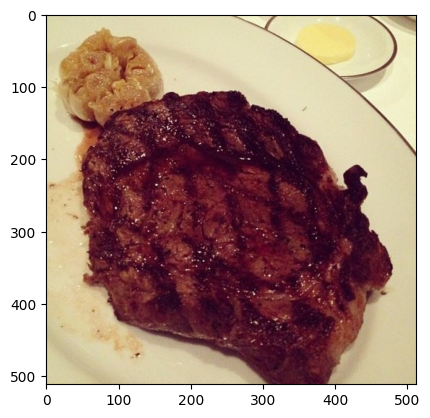

In [72]:
import random
import matplotlib.pyplot as plt

random_img_path = random.sample(test_data_paths, k=1)[0]
print(f"{random_img_path}\n")

img = Image.open(random_img_path)
plt.imshow(img);

pred_dict, pred_time = predict(img=img)
print(f"{pred_dict}\n")
print(pred_time)

## Project Structure: `foodvision_mini`

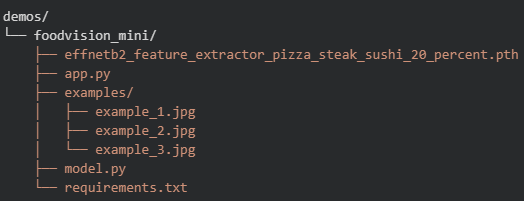

## Sampling Random Test Image Paths

In [74]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3401466.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2819945.jpg']]

## FoodVision Mini Demo (Gradio Interface)

In [88]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Thanks to [Daniel Bourke (mrdbourke)](https://github.com/mrdbourke/pytorch-deep-learning/)"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# demo.launch(debug=False, share=True)

## Preparing the foodvision_mini Demo Directory

In [76]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

os.listdir("demos/foodvision_mini")

[]

## Preparing Example Images for FoodVision Mini

In [78]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path(r"data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg"),
                            Path(r"data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg"),
                            Path(r"data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg")]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


## Moving the EfficientNetB2 Model into FoodVision Mini

In [83]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = r"models/effnetb2.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / r"effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Try to move the model file
try:
    print(f"[INFO] trying to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)
    print(f"[INFO] Model move complete!")

except:
    print(f"[INFO] Couldn't find the model!")

[INFO] trying to move models/effnetb2.pth to demos/foodvision_mini/effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete!


## `model.py` - EfficientNetB2 for FoodVision Mini

In [84]:
%%writefile demos/foodvision_mini/model.py

from torch import nn
import torch
import torchvision

def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):

    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transformer = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed=seed)

    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transformer

Writing demos/foodvision_mini/model.py


## `app.py` - Gradio Interface for FoodVision Mini

In [92]:
# %%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch

from demos.foodvision_mini.model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Dict

class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)
effnetb2.load_state_dict(
    torch.load(
        fr'demos/foodvision_mini/effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth',
                         map_location=torch.device("cpu")))

# predict function
def predict(img):

    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_labels_and_probs = {}

    for i in range(len(class_names)):
        label = class_names[i]
        prob = float(pred_probs[0][i])
        pred_labels_and_probs[label] = prob

    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    return pred_labels_and_probs, pred_time

title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Thanks to [Daniel Bourke (mrdbourke)](https://github.com/mrdbourke/pytorch-deep-learning/)"

example_list = [["demos/foodvision_mini/examples/" + example]
                for example in os.listdir("demos/foodvision_mini/examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7ba6b495939f4f110d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
